In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths
import os
import os.path as osp
import cv2
import logging
import argparse
import motmetrics as mm
import numpy as np
import torch

from tracker.multitracker import JDETracker
from tracking_utils import visualization as vis
from tracking_utils.log import logger
from tracking_utils.timer import Timer
from tracking_utils.evaluation import Evaluator
import datasets.dataset.jde as datasets

from tracking_utils.utils import mkdir_if_missing
from opts import opts


def write_results(filename, results, data_type):
    if data_type == 'mot':
        save_format = '{frame},{id},{x1},{y1},{w},{h},1,-1,-1,-1\n'
    elif data_type == 'kitti':
        save_format = '{frame} {id} pedestrian 0 0 -10 {x1} {y1} {x2} {y2} -10 -10 -10 -1000 -1000 -1000 -10\n'
    else:
        raise ValueError(data_type)

    with open(filename, 'w') as f:
        for frame_id, tlwhs, track_ids in results:
            if data_type == 'kitti':
                frame_id -= 1
            for tlwh, track_id in zip(tlwhs, track_ids):
                if track_id < 0:
                    continue
                x1, y1, w, h = tlwh
                x2, y2 = x1 + w, y1 + h
                line = save_format.format(frame=frame_id, id=track_id, x1=x1, y1=y1, x2=x2, y2=y2, w=w, h=h)
                f.write(line)
    logger.info('save results to {}'.format(filename))


def eval_seq(opt, dataloader, data_type, result_filename, save_dir=None, show_image=True, frame_rate=30):
    if save_dir:
        mkdir_if_missing(save_dir)
    tracker = JDETracker(opt, frame_rate=frame_rate)
    timer = Timer()
    results = []
    frame_id = 0
    for path, img, img0 in dataloader:
        if frame_id % 20 == 0:
            logger.info('Processing frame {} ({:.2f} fps)'.format(frame_id, 1. / max(1e-5, timer.average_time)))

        # run tracking
        timer.tic()
        blob = torch.from_numpy(img).cuda().unsqueeze(0)
        online_targets = tracker.update(blob, img0)
        online_tlwhs = []
        online_ids = []
        for t in online_targets:
            tlwh = t.tlwh
            tid = t.track_id
            vertical = tlwh[2] / tlwh[3] > 1.6
            if tlwh[2] * tlwh[3] > opt.min_box_area and not vertical:
                online_tlwhs.append(tlwh)
                online_ids.append(tid)
        timer.toc()
        # save results
        results.append((frame_id + 1, online_tlwhs, online_ids))
        if show_image or save_dir is not None:
            online_im = vis.plot_tracking(img0, online_tlwhs, online_ids, frame_id=frame_id,
                                          fps=1. / timer.average_time)
        if show_image:
            cv2.imshow('online_im', online_im)
        if save_dir is not None:
            cv2.imwrite(os.path.join(save_dir, '{:05d}.jpg'.format(frame_id)), online_im)
        frame_id += 1
    # save results
    write_results(result_filename, results, data_type)
    return frame_id, timer.average_time, timer.calls


def main(opt, data_root='/data/MOT16/train', det_root=None, seqs=('MOT16-05',), exp_name='demo',
         save_images=False, save_videos=False, show_image=True):
    logger.setLevel(logging.INFO)
    result_root = os.path.join(data_root, '..', 'results', exp_name)
    #print(data_root)
    mkdir_if_missing(result_root)
    data_type = 'mot'

    # run tracking
    accs = []
    n_frame = 0
    timer_avgs, timer_calls = [], []
    for seq in seqs:
        output_dir = os.path.join(data_root, '..', 'outputs', exp_name, seq) if save_images or save_videos else None
        logger.info('start seq: {}'.format(seq))
        dataloader = datasets.LoadImages(osp.join(data_root, seq, 'img1'), opt.img_size)
        result_filename = os.path.join(result_root, '{}.txt'.format(seq))
        meta_info = open(os.path.join(data_root, seq, 'seqinfo.ini')).read()
        frame_rate = int(meta_info[meta_info.find('frameRate') + 10:meta_info.find('\nseqLength')])
        nf, ta, tc = eval_seq(opt, dataloader, data_type, result_filename,
                              save_dir=output_dir, show_image=show_image, frame_rate=frame_rate)
        n_frame += nf
        timer_avgs.append(ta)
        timer_calls.append(tc)

        # eval
        logger.info('Evaluate seq: {}'.format(seq))
        evaluator = Evaluator(data_root, seq, data_type)
        accs.append(evaluator.eval_file(result_filename))
        if save_videos:
            output_video_path = osp.join(output_dir, '{}.mp4'.format(seq))
            cmd_str = 'ffmpeg -f image2 -i {}/%05d.jpg -c:v copy {}'.format(output_dir, output_video_path)
            os.system(cmd_str)
    timer_avgs = np.asarray(timer_avgs)
    timer_calls = np.asarray(timer_calls)
    all_time = np.dot(timer_avgs, timer_calls)
    avg_time = all_time / np.sum(timer_calls)
    logger.info('Time elapsed: {:.2f} seconds, FPS: {:.2f}'.format(all_time, 1.0 / avg_time))

    # get summary
    metrics = mm.metrics.motchallenge_metrics
    mh = mm.metrics.create()
    summary = Evaluator.get_summary(accs, seqs, metrics)
    strsummary = mm.io.render_summary(
        summary,
        formatters=mh.formatters,
        namemap=mm.io.motchallenge_metric_names
    )
    print(strsummary)
    Evaluator.save_summary(summary, os.path.join(result_root, 'summary_{}.xlsx'.format(exp_name)))


# if __name__ == '__main__':
#     os.environ['CUDA_VISIBLE_DEVICES'] = '0'
#     opt = opts().init()

#     if not opt.val_mot16:
#         seqs_str = '''KITTI-13
#                       KITTI-17
#                       ADL-Rundle-6
#                       PETS09-S2L1
#                       TUD-Campus
#                       TUD-Stadtmitte'''
#         data_root = os.path.join(opt.data_dir, 'MOT15/images/train')
#     else:
#         seqs_str = '''MOT16-02
#                       MOT16-04
#                       MOT16-05
#                       MOT16-09
#                       MOT16-10
#                       MOT16-11
#                       MOT16-13'''
#         data_root = os.path.join(opt.data_dir, 'MOT16/train')
#     if opt.test_mot16:
#         seqs_str = '''MOT16-01
#                       MOT16-03
#                       MOT16-06
#                       MOT16-07
#                       MOT16-08
#                       MOT16-12
#                       MOT16-14'''
#         data_root = os.path.join(opt.data_dir, 'MOT16/test')
#     if opt.test_mot15:
#         seqs_str = '''ADL-Rundle-1
#                       ADL-Rundle-3
#                       AVG-TownCentre
#                       ETH-Crossing
#                       ETH-Jelmoli
#                       ETH-Linthescher
#                       KITTI-16
#                       KITTI-19
#                       PETS09-S2L2
#                       TUD-Crossing
#                       Venice-1'''
#         data_root = os.path.join(opt.data_dir, 'MOT15/images/test')
#     if opt.test_mot17:
#         seqs_str = '''MOT17-01-SDP
#                       MOT17-03-SDP
#                       MOT17-06-SDP
#                       MOT17-07-SDP
#                       MOT17-08-SDP
#                       MOT17-12-SDP
#                       MOT17-14-SDP'''
#         data_root = os.path.join(opt.data_dir, 'MOT17/images/test')
#     if opt.val_mot17:
#         seqs_str = '''MOT17-02-SDP
#                       MOT17-04-SDP
#                       MOT17-05-SDP
#                       MOT17-09-SDP
#                       MOT17-10-SDP
#                       MOT17-11-SDP
#                       MOT17-13-SDP'''
#         data_root = os.path.join(opt.data_dir, 'MOT17/images/train')
#     if opt.val_mot15:
#         seqs_str = '''KITTI-13
#                       KITTI-17
#                       ETH-Bahnhof
#                       ETH-Sunnyday
#                       PETS09-S2L1
#                       TUD-Campus
#                       TUD-Stadtmitte
#                       ADL-Rundle-6
#                       ADL-Rundle-8
#                       ETH-Pedcross2
#                       TUD-Stadtmitte'''
#         data_root = os.path.join(opt.data_dir, 'MOT15/images/train')
#     if opt.val_mot20:
#         seqs_str = '''MOT20-01
#                       MOT20-02
#                       MOT20-03
#                       MOT20-05
#                       '''
#         data_root = os.path.join(opt.data_dir, 'MOT20/images/train')
#     if opt.test_mot20:
#         seqs_str = '''MOT20-04
#                       MOT20-06
#                       MOT20-07
#                       MOT20-08
#                       '''
#         data_root = os.path.join(opt.data_dir, 'MOT20/images/test')
#     seqs = [seq.strip() for seq in seqs_str.split()]

#     main(opt,
#          data_root=data_root,
#          seqs=seqs,
#          exp_name='MOT15_val_all_dla34',
#          show_image=False,
#          save_images=False,
#          save_videos=False)


In [1]:
import numpy as np

In [6]:
a = np.arange(4).reshape(1,4)

In [7]:
b = np.array([1,2]).reshape(1,2)

ValueError: operands could not be broadcast together with shapes (1,4) (1,2) 

In [3]:
import cv2

In [5]:
cap = cv2.VideoCapture(video_path)

In [6]:
s,fr = cap.read()

In [7]:
os.mkdir('result3')

In [2]:
video_path = 'random people walk studies.mp4'

In [5]:
dl = datasets.LoadVideo(video_path, (1088,608))

Lenth of the video: 4706 frames


In [6]:
result_filename = os.path.join('result3', '{}.txt'.format('output'))

In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os


class opts(object):
    def __init__(self):
        # basic experiment setting
        self.task = 'mot'
        self.dataset = 'jde'
        self.exp_id = 'default'
        self.test = True
        #self.parser.add_argument('--load_model', default='../models/ctdet_coco_dla_2x.pth',
                                 #help='path to pretrained model')
        self.load_model = ''
        self.resume = True

        # system
        self.gpus = '0, 1'
        self.num_workers = 8
        self.not_cuda_benchmark = True
        self.seed = 317
        # log
        self.print_iter = 0
        self.hide_data_time = True
        self.save_all = True
        self.metric = 'loss'
        self.vis_thresh = 0.5
        # model
        self.arch = 'dla_34'
        self.head_conv = -1
        self.down_ratio = 4
        # input
        self.input_res = -1
        self.input_h = -1
        self.input_w = -1
        # train
        self.lr = 1e-4
        self.lr_step = '20,27'
        self.num_epochs = 30
        self.batch_size = 12
        self.master_batch_size = -1
        self.num_iters = -1
        self.val_intervals = 5
        self.trainval = True
        # test
        self.K = 128
        self.not_prefetch_test = True
        self.fix_res = True
        self.keep_res = True
        # tracking
        self.test_mot16 = False
        self.val_mot15 = False
        self.test_mot15 = False
        self.val_mot16 = False
        self.test_mot17 = False
        self.val_mot17 = False
        self.val_mot20 = False
        self.test_mot20 = False
        self.conf_thres = 0.6
        self.det_thres = 0.3
        self.nms_thres = 0.4
        self.track_buffer = 30
        self.min_box_area = 200
        self.input_video = '../videos/MOT16-03.mp4'
        self.output_format = 'video'
        self.output_root = '../results'

        # mot
        self.data_cfg = '../src/lib/cfg/data.json'
        self.data_dir = '../../data/yfzhang/MOT/JDE'

        # loss
        self.mse_loss = True

        self.reg_loss = 'l1'
        self.hm_weight = 1
        self.off_weight = 1
        self.wh_weight = 0.1
        self.id_loss = 'ce'
        self.id_weight = 1.0
        self.reid_dim = 512

        self.norm_wh = True
        self.dense_wh = True
        self.cat_spec_wh = True
        self.not_reg_offset = False

    def parse(self, args=''):
        opt = self
        opt.gpus_str = opt.gpus
        opt.gpus = [int(gpu) for gpu in opt.gpus.split(',')]
        opt.gpus = [i for i in range(len(opt.gpus))] if opt.gpus[0] >=0 else [-1]
        opt.lr_step = [int(i) for i in opt.lr_step.split(',')]

        opt.fix_res = not opt.keep_res
        print('Fix size testing.' if opt.fix_res else 'Keep resolution testing.')
        opt.reg_offset = not opt.not_reg_offset

        if opt.head_conv == -1: # init default head_conv
          opt.head_conv = 256 if 'dla' in opt.arch else 256
        opt.pad = 31
        opt.num_stacks = 1

        if opt.trainval:
          opt.val_intervals = 100000000

        if opt.master_batch_size == -1:
          opt.master_batch_size = opt.batch_size // len(opt.gpus)
        rest_batch_size = (opt.batch_size - opt.master_batch_size)
        opt.chunk_sizes = [opt.master_batch_size]
        for i in range(len(opt.gpus) - 1):
          slave_chunk_size = rest_batch_size // (len(opt.gpus) - 1)
          if i < rest_batch_size % (len(opt.gpus) - 1):
            slave_chunk_size += 1
          opt.chunk_sizes.append(slave_chunk_size)
        print('training chunk_sizes:', opt.chunk_sizes)

        opt.root_dir = os.path.join(os.path.dirname('__file__'), '..', '..')
        opt.exp_dir = os.path.join(opt.root_dir, 'exp', opt.task)
        opt.save_dir = os.path.join(opt.exp_dir, opt.exp_id)
        opt.debug_dir = os.path.join(opt.save_dir, 'debug')
        print('The output will be saved to ', opt.save_dir)

        if opt.resume and opt.load_model == '':
          model_path = opt.save_dir[:-4] if opt.save_dir.endswith('TEST') \
                      else opt.save_dir
          opt.load_model = os.path.join(model_path, 'model_last.pth')
        return opt

    def update_dataset_info_and_set_heads(self, opt, dataset):
        input_h, input_w = dataset.default_resolution
        opt.mean, opt.std = dataset.mean, dataset.std
        opt.num_classes = dataset.num_classes

        # input_h(w): opt.input_h overrides opt.input_res overrides dataset default
        input_h = opt.input_res if opt.input_res > 0 else input_h
        input_w = opt.input_res if opt.input_res > 0 else input_w
        opt.input_h = opt.input_h if opt.input_h > 0 else input_h
        opt.input_w = opt.input_w if opt.input_w > 0 else input_w
        opt.output_h = opt.input_h // opt.down_ratio
        opt.output_w = opt.input_w // opt.down_ratio
        opt.input_res = max(opt.input_h, opt.input_w)
        opt.output_res = max(opt.output_h, opt.output_w)

        if opt.task == 'mot':
          opt.heads = {'hm': opt.num_classes,
                       'wh': 2 if not opt.cat_spec_wh else 2 * opt.num_classes,
                       'id': opt.reid_dim}
          if opt.reg_offset:
            opt.heads.update({'reg': 2})
          opt.nID = dataset.nID
          opt.img_size = (1088, 608)
        else:
          assert 0, 'task not defined!'
        print('heads', opt.heads)
        return opt

    def init(self, args=''):
        default_dataset_info = {
          'mot': {'default_resolution': [608, 1088], 'num_classes': 1,
                    'mean': [0.408, 0.447, 0.470], 'std': [0.289, 0.274, 0.278],
                    'dataset': 'jde', 'nID': 14455},
        }
        class Struct:
          def __init__(self, entries):
            for k, v in entries.items():
              self.__setattr__(k, v)
        opt = self.parse(args)
        dataset = Struct(default_dataset_info[opt.task])
        opt.dataset = dataset.dataset
        opt = self.update_dataset_info_and_set_heads(opt, dataset)
        return opt


In [9]:
opt = opts().init()
opt.load_model = '../models/all_dla34.pth'
frame_rate = 30
show_image = False
output_dir = 'result3'
nf, ta, tc = eval_seq(opt, dl, 'mot', result_filename,
                              save_dir=output_dir, show_image=show_image, frame_rate=frame_rate)

Keep resolution testing.
training chunk_sizes: [6, 6]
The output will be saved to  ../../exp/mot/default
heads {'hm': 1, 'wh': 2, 'id': 512, 'reg': 2}
Creating model...
loaded ../models/all_dla34.pth, epoch 10


2020-05-11 22:28:34 [INFO]: Processing frame 0 (100000.00 fps)
2020-05-11 22:28:39 [DEBUG]: ===========Frame 1==========
2020-05-11 22:28:39 [DEBUG]: Activated: [1, 2, 3, 4, 5, 6, 7, 8, 9]
2020-05-11 22:28:39 [DEBUG]: Refind: []
2020-05-11 22:28:39 [DEBUG]: Lost: []
2020-05-11 22:28:39 [DEBUG]: Removed: []
2020-05-11 22:28:40 [DEBUG]: ===========Frame 2==========
2020-05-11 22:28:40 [DEBUG]: Activated: [1, 2, 3, 4, 5, 6, 7, 8, 9]
2020-05-11 22:28:40 [DEBUG]: Refind: []
2020-05-11 22:28:40 [DEBUG]: Lost: []
2020-05-11 22:28:40 [DEBUG]: Removed: []
2020-05-11 22:28:41 [DEBUG]: ===========Frame 3==========
2020-05-11 22:28:41 [DEBUG]: Activated: [1, 2, 3, 4, 5, 6, 7, 8, 9]
2020-05-11 22:28:41 [DEBUG]: Refind: []
2020-05-11 22:28:41 [DEBUG]: Lost: []
2020-05-11 22:28:41 [DEBUG]: Removed: []
2020-05-11 22:28:41 [DEBUG]: ===========Frame 4==========
2020-05-11 22:28:41 [DEBUG]: Activated: [1, 2, 3, 4, 5, 6, 7, 8, 9]
2020-05-11 22:28:41 [DEBUG]: Refind: []
2020-05-11 22:28:41 [DEBUG]: Lost: [

In [10]:
from glob import glob

In [11]:
all_images = sorted(glob('result3/*'))

In [12]:
len(all_images)

4707

In [13]:
print(cv2.imread(all_images[0]).shape)

(1080, 1920, 3)


In [14]:

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(f'video_output_new.avi', fourcc, 25.0, (1080,720))

for image  in all_images:
    frame = cv2.resize(cv2.imread(image),(1080,720))
    out.write(frame)
# while ret:

#     aligned_faces,bbox,points = model.get_input(frame)
#     if bbox is None:
#         out.write(frame)
#         ret,frame = cap.read()
#         continue
#     faces , keypoints , boxes = model.get_face_patch(frame,bbox,points)

#     for face,im,box,kp in zip(faces,aligned_faces,boxes,points):
#         sim = []
#         feature = model.get_feature(im)
#         for saved_feature in saved_features:
#             sim.append(cosine(feature,saved_feature))
#         if max(sim)>=0.2:
#             name = saved_faces[np.argmax(sim)]
#         else: 
#             bbox = box.flatten()[:4]
#             keypoint = kp.flatten()
#             datapoint = np.concatenate((bbox,keypoint)).astype(np.float32)
#             datapoint = torch.from_numpy(datapoint).to(torch.device('cuda'))
#             output = model_side_face(datapoint[None])
#             if output.argmax() == 1:
#                 name = 'Unknown_side_face'
#             else:
#                 name = 'Unknown'
#         img_name = str(np.random.randint(0,10000))
#         while img_name in os.listdir(f'../Output/side_face_exp/Experimentation/similarity_0.2/{name}'):
#             img_name = str(np.random.randint(0,10000))
#         plt.imsave(f'../Output/side_face_exp/Experimentation/similarity_0.2/{name}/{img_name}.jpg',face)
#         cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0,255,0), 2)
#         if name!='Unknown':
#             cv2.putText(frame,f'{name}',(box[0],box[1]),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
#     frame = cv2.resize(frame,(1080,720))
#     out.write(frame)
#     ret,frame = cap.read()

# cap.release()
# out.release()
# print("done")



error: OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [7]:
import matplotlib.pyplot as plt

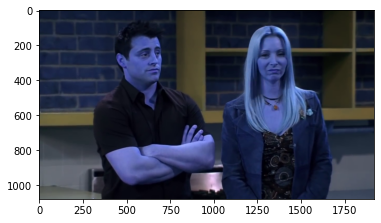

In [15]:
plt.imshow(k)

In [14]:
print(i)

1588


In [16]:
5/30*30

5.0

In [ ]:
meta_info = open(os.path.join(data_root, seq, 'seqinfo.ini')).read()
frame_rate = int(meta_info[meta_info.find('frameRate') + 10:meta_info.find('\nseqLength')])